# Analyse de la structure électronique du KLaTe2

## Introduction
### Ce notebook analyse la structure de bande électronique d'un matériau donné. Il détermine la bande interdite, la dispersion des bandes de valence et conduction, et calcule la masse effective des électrons et trous.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter, DosPlotter

In [3]:
# Chargement des données
API_KEY = "71t7m37H7F5Jw2PfGOrlKxgH4ZbRQh3W" 
MP_ID = "mp-11739" 

In [4]:
with MPRester(API_KEY) as m:
    el_bs = m.get_bandstructure_by_material_id(MP_ID)
    el_dos = m.get_dos_by_material_id(MP_ID)

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Détermination de la bande interdite

L'énergie de la bande interdite d'un matériau est un paramètre clé qui permet de distinguer différents types de matériaux :

- **Métaux** : bande interdite quasi nulle (~ 0 eV).
- **Semi-conducteurs** : bande interdite typiquement entre 0 et 3 eV.
- **Isolants** : bande interdite généralement supérieure à 3 eV.

L’écart énergétique entre le sommet de la bande de valence (VBM) et le bas de la bande de conduction (CBM) peut être de deux types :

1. **Bande interdite directe** : le CBM et le VBM sont situés au même vecteur d’onde (k), permettant une transition électronique sans changement de moment.
2. **Bande interdite indirecte** : le CBM et le VBM sont à des positions k différentes, ce qui nécessite un transfert de moment, souvent par interaction avec un phonon.

Dans ce notebook, nous utiliserons la fonction `get_band_gap()` pour calculer cette bande interdite et déterminer si elle est directe ou indirecte.

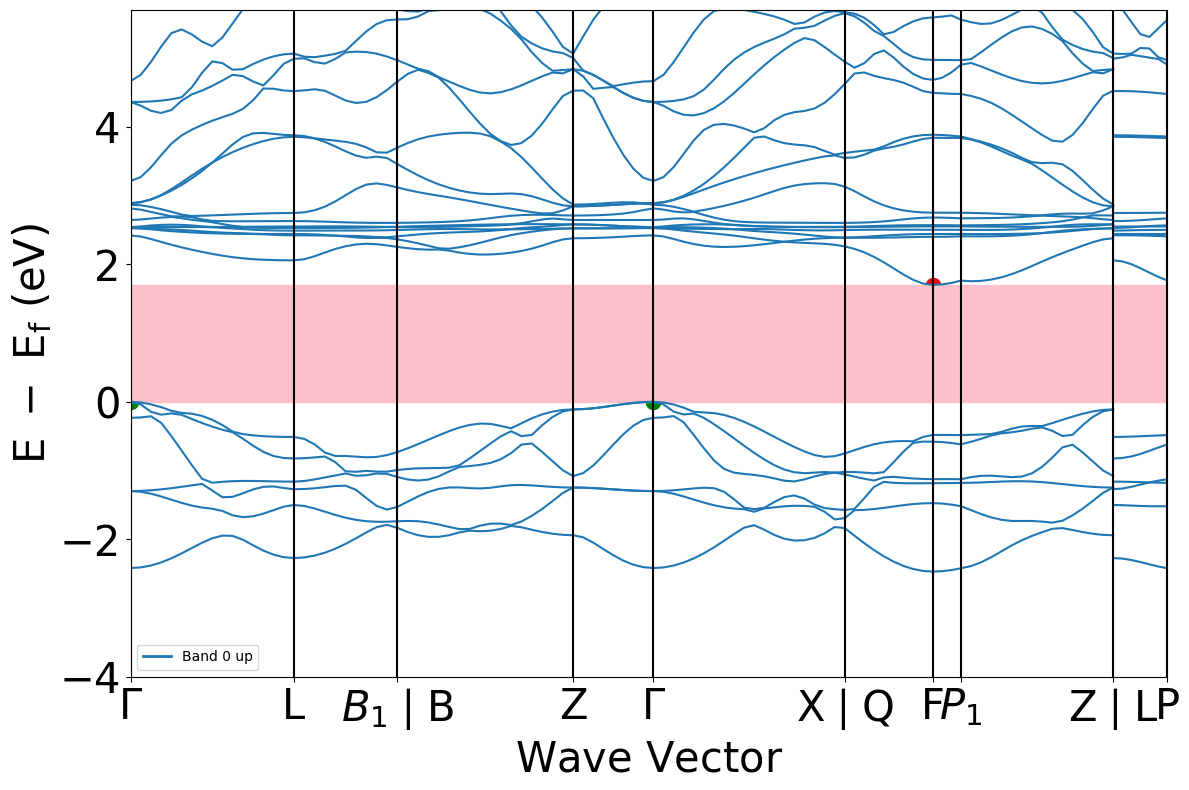

In [9]:
# Affichage des bandes électroniques
fig_el_bs = BSPlotter(el_bs)
band_gap = el_bs.get_band_gap()

data = fig_el_bs.bs_plot_data()
energy = band_gap.get('energy')
distance = data.get('ticks').get('distance')

fig_el_bs.get_plot(vbm_cbm_marker=True)
plt.fill_between(np.linspace(distance[0], distance[-1], 2), 0, energy, color = "pink")

In [12]:
# Détermination de la bande interdite
vbm_info = el_bs.get_vbm()
cbm_info = el_bs.get_cbm()

# Calcul de l'écart énergétique entre le bas de la bande de conduction (CBM) et le sommet de la bande de valence (VBM)
gap = cbm_info["energy"] - vbm_info["energy"] 
print(f"Bande interdite (gap) : {gap} eV")

# Vérification
print(f"Vérification - Bande interdite : {band_gap['energy']} eV")

#Bande directe ou indirecte
if band_gap["direct"] is True:
    print("La bande interdite de ce matériau est directe")
if band_gap["direct"] is False:
    print("La bande interdite de ce matériau est indirecte")

defaultdict(<class 'list'>, {<Spin.up: 1>: [14, 15]})
defaultdict(<class 'list'>, {<Spin.up: 1>: [16]})
Bande interdite (gap) : 1.7012999999999994 eV
Vérification - Bande interdite : 1.7012999999999994 eV
La bande interdite de ce matériau est indirecte


## Analyse de la dispersion

L'analyse de la dispersion consiste à étudier la variation de l'énergie des bandes électroniques en fonction de la direction dans l'espace des moments. La dispersion est liée à la pente de la courbe dE/dk, où E est l'énergie et k est le vecteur d'onde. Une grande pente indique une forte dispersion, c'est-à-dire une variation rapide de l'énergie, tandis qu'une faible pente montre une faible dispersion. Une forte dispersion est généralement associée à une meilleure mobilité des électrons, car les électrons peuvent se déplacer plus facilement dans ces directions. 

Pour identifier les directions de forte et faible dispersion, on observe les variations de dE/dk dans les courbes de la bande de valence et de conduction, et on peut les illustrer par des flèches sur une figure.


Sur la dernière bande de valence, la plus grande dispersion se trouve sur la branche 4, et la plus petite sur la branche 3.

Pour la première bande de conduction, la plus grande dispersion se trouve sur la branche 5, et la plus petite sur la branche 3.



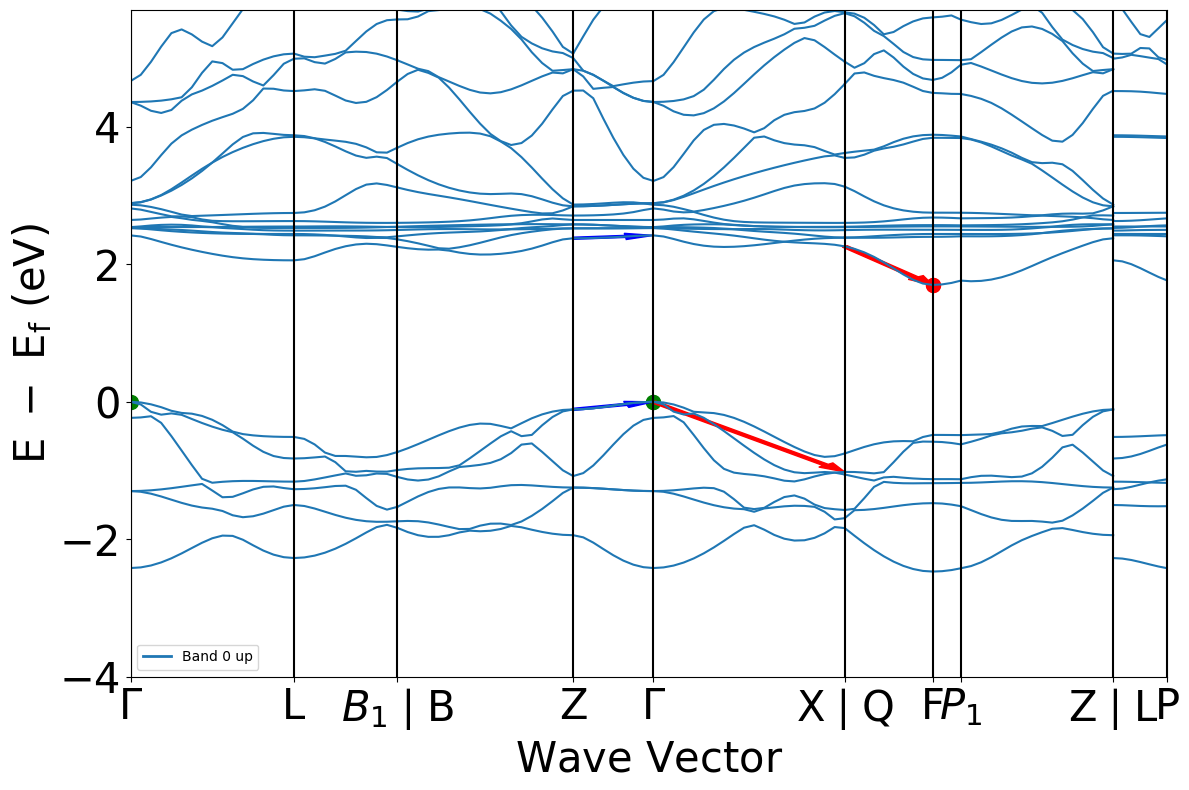

In [22]:
# Récupération des données
data = fig_el_bs.bs_plot_data()
distances = data['distances']
energy = data['energy']

# Récupération des indices des bandes
vbm = el_bs.get_vbm()
cbm = el_bs.get_cbm()

vbm_index = list(vbm["band_index"].values())[0][0]  # Dernière bande de valence
cbm_index = list(cbm["band_index"].values())[0][0]  # Première bande de conduction

# Fonction pour calculer la dispersion (pente) entre deux points
def calculate_dispersion(index, band_type):
    dispersion = []
    for i in range(len(distances)):
        dx = distances[i][0] - distances[i][-1]
        
        dy = energy['1'][i][index][0] - energy['1'][i][index][-1]
        
        slope = abs(dy / dx)
        dispersion.append(slope)
    return dispersion

# Calcul des dispersions pour la bande de valence et de conduction
Valence_disp = calculate_dispersion(vbm_index, "valence")
Conduction_disp = calculate_dispersion(cbm_index, "conduction")

# Indices des dispersions maximales et minimales
Valence_max = Valence_disp.index(max(Valence_disp))
Valence_min = Valence_disp.index(min(Valence_disp))
Cond_max = Conduction_disp.index(max(Conduction_disp))
Cond_min = Conduction_disp.index(min(Conduction_disp))

# Affichage des résultats avec les indices des branches de la Brillouin Zone
print(f"Sur la dernière bande de valence, la plus grande dispersion se trouve sur la branche {Valence_max}, "
      f"et la plus petite sur la branche {Valence_min}.\n")
print(f"Pour la première bande de conduction, la plus grande dispersion se trouve sur la branche {Cond_max}, "
      f"et la plus petite sur la branche {Cond_min}.\n")

# Tracé du diagramme des bandes électroniques
fig_el_bs.get_plot(vbm_cbm_marker=True)

# Fonction pour tracer les flèches de dispersion
def plot_arrow(index, band_index, color):
    plt.arrow(distances[index][0], energy['1'][index][band_index][0], 
              distances[index][-1] - distances[index][0],
              energy['1'][index][band_index][-1] - energy['1'][index][band_index][0],
              width=0.03, length_includes_head=True, color=color)

# Tracer les flèches pour les dispersions maximales et minimales
plot_arrow(Valence_min, vbm_index, 'blue')  # Valence min dispersion
plot_arrow(Valence_max, vbm_index, 'red')   # Valence max dispersion
plot_arrow(Cond_min, cbm_index, 'blue')     # Conduction min dispersion
plot_arrow(Cond_max, cbm_index, 'red')      # Conduction max dispersion

plt.show()


La plus grande dispersion (flèche rouge) dans la bande de valence se trouve sur le chemin **Τ → X** et la plus petite (flèche bleue) sur **Z → Τ**.  
La plus grande dispersion dans la bande de conduction se trouve sur le chemin **Q → F** et la plus petite sur **Z → Τ**.

## Calcul de la masse effective

### Définition de la Masse Effective  
La **masse effective** d'un électron est une quantité qui décrit comment une particule chargée se déplace dans un cristal sous l'influence d'un champ électrique ou magnétique. Contrairement à la masse réelle d'un électron dans le vide, la masse effective prend en compte l'interaction de l'électron avec le réseau cristallin, ce qui modifie son inertie.

Elle est définie en supposant une **dispersion parabolique** de la relation énergie-impulsion, ce qui est une bonne approximation près du sommet de la bande de valence et de la base de la bande de conduction.

---

### Formule de la Masse Effective  

En supposant que la relation entre l'énergie $E$ et le vecteur d'onde $k$ suit une loi quadratique de la forme :

$$
E(k) = a k^2 + b k + c
$$

La **masse effective** est définie comme :

$$
m^* = \frac{\hbar^2}{\frac{d^2E}{dk^2}}
$$

où :

- $m^*$ est la masse effective de l'électron ou du trou,
- $\hbar$ est la constante de Planck réduite ($\hbar = \frac{h}{2\pi}$),
- $\frac{d^2E}{dk^2}$ est la dérivée seconde de l'énergie par rapport au vecteur d'onde $k$, qui représente la courbure de la bande d'énergie.

Lorsque la dispersion suit une loi parabolique ($E(k) \propto k^2$), la masse effective est constante dans la région étudiée.

---

### Approximation de la Dérivée Seconde de l'Énergie  

Dans un calcul numérique, la dérivée seconde de $E(k)$ est souvent approximée par une **différence finie** :

$$
\frac{d^2E}{dk^2} \approx \frac{E(k+\Delta k) - 2E(k) + E(k-\Delta k)}{(\Delta k)^2}
$$

où :

- $E(k)$ est l'énergie pour une valeur donnée de $k$,
- $E(k+\Delta k)$ et $E(k-\Delta k)$ sont les énergies pour des valeurs légèrement décalées de $k$,
- $\Delta k$ est l'intervalle entre deux valeurs de $k$.

Cette approximation permet de calculer la courbure de la bande d'énergie à partir de données discrètes obtenues par des simulations ou des mesures expérimentales.

---

### Interprétation Physique  

- **Si la courbure est grande ($\frac{d^2E}{dk^2}$ élevé)** : la bande est très incurvée, ce qui signifie que la masse effective est faible. Les électrons ou trous sont alors très mobiles.
- **Si la courbure est faible ($\frac{d^2E}{dk^2}$ petit)** : la masse effective est grande, indiquant que la particule se déplace avec plus d’inertie.


In [30]:
# Constantes
h_barre = 1.054571818 * 10**(-34)  # Constante de Planck réduite [J.s]
eV = 1.602176563 * 10**(-19)  # Conversion eV à Joules
A = 10**(-10)  # Conversion en Angströms (1 Å = 10^-10 m)

# Récupération des valeurs de k et des énergies pour les bandes de valence et de conduction
k_values = np.array([d[0] for d in distances])  # Extraction des valeurs k
E_valence = np.array([e[vbm_index][0] for e in energy['1']])  # Énergie pour la bande de valence
E_conduction = np.array([e[cbm_index][0] for e in energy['1']])  # Énergie pour la bande de conduction

# Fonction pour estimer la dérivée seconde de l'énergie et calculer la masse effective
def effective_mass(E, idx_max):
    # Indices à gauche et à droite du point d'intérêt (sommet ou base)
    right = min(idx_max + 1, len(k_values) - 1)
    left = max(idx_max - 1, 0)
    
    # Approximation de la dérivée seconde de l'énergie par rapport à k
    dE_dk2 = (E[right] - 2 * E[idx_max] + E[left]) / ((k_values[right] - k_values[idx_max])**2)
    
    # Calcul de la masse effective (en kg) selon la formule standard
    m_effect = h_barre**2 / (dE_dk2 * A**2 * eV)  
    
    return m_effect

# Calcul de la masse effective au sommet de la bande de valence (VBM) et à la base de la bande de conduction (CBM)
m_eff_valence = effective_mass(E_valence, np.argmax(E_valence))  # Masse effective au sommet de la bande de valence
m_eff_conduction = effective_mass(E_conduction, np.argmin(E_conduction))  # Masse effective à la base de la bande de conduction

# Affichage des résultats avec un format scientifique
print(f"Masse effective au sommet de la bande de valence (VBM) : {m_eff_valence:.2e} kg")
print(f"Masse effective à la base de la bande de conduction (CBM) : {m_eff_conduction:.2e} kg")


Masse effective au sommet de la bande de valence (VBM) : -5.10e-30 kg
Masse effective à la base de la bande de conduction (CBM) : 2.01e-31 kg
